In [82]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, matthews_corrcoef, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [83]:
"""MUST CHANGE THESE VARIABLES BEFORE RUNNING THE SCRIPT:
Protein_type, either "transmembrane", "collagen" or "globular"
Residues_or_proteins, either "residues" or "proteins"""

protein_type = "collagens"  # "transmembrane", "collagens" or "globular"
residues_or_proteins = "proteins"  # "residues" or "proteins"
filename = 'C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\Data\\data_for_all_dvd.csv'
data = pd.read_csv(f"{filename}", index_col=False)
data

,gene,variant,stability_WT,stability_MUT,stability_delta,pathogenicity,Absolute value of delta,blosum,hydrophobicity_WT,hydrophobicity_MUT,...,sasa_delta,secondary_structure,sequence_length,protein_contain_transmembrane,is_residue_transmembranal,aa_WT,aa_MUT,RSA_WT,RSA_MUT,source
0,POLR1D,L111P,55.4166,59.2536,3.8370,pathogenic,3.8370,-3,3.8,-1.6,...,-26.79,Helix,133,False,False,L,P,0.445445,0.378506,dvd
1,POLR1D,T50I,52.5256,53.9242,1.3986,pathogenic,1.3986,-1,-0.7,4.5,...,37.23,Helix,133,False,False,T,I,0.653988,0.737590,dvd
2,POLR1D,L55V,53.5827,56.1836,2.6009,pathogenic,2.6009,1,3.8,4.2,...,-0.01,Helix,133,False,False,L,V,0.000052,0.000000,dvd
3,POLR1D,G99S,53.3779,55.2641,1.8862,pathogenic,1.8862,0,-0.4,-0.8,...,2.56,Helix,133,False,False,G,S,0.011237,0.025524,dvd
4,POLR1D,C68W,55.1261,90.0561,34.9300,pathogenic,34.9300,-2,2.5,-0.9,...,0.41,Beta strand,133,False,False,C,W,0.002838,0.003144,dvd
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5469,PJVK,G292R,211.5760,215.0030,3.4270,benign,3.4270,-2,-0.4,-4.5,...,146.47,Loop,352,False,False,G,R,0.759278,0.830642,dvd
5470,PJVK,R265C,211.4450,211.7910,0.3460,benign,0.3460,-3,-4.5,2.5,...,-110.68,Loop,352,False,False,R,C,0.821547,0.723176,dvd
5471,PJVK,M260V,209.8750,211.5100,1.6350,benign,1.6350,1,1.9,4.2,...,-31.74,Loop,352,False,False,M,V,0.484729,0.404000,dvd
5472,PJVK,R265G,211.4450,211.7550,0.3100,benign,0.3100,-2,-4.5,-0.4,...,-154.07,Loop,352,False,False,R,G,0.821547,0.656082,dvd


In [84]:
if protein_type == "transmembrane" and residues_or_proteins == "residues":
    # Remove globular proteins, using column "protein_contain_transmembrane"
    data = data[data["protein_contain_transmembrane"] == 1]
    # Remove variants in globular residues
    data = data[data["is_residue_transmembranal"] == 1]
    
if protein_type == "globular" and residues_or_proteins == "proteins":
    # Remove transmembrane proteins, using column "protein_contain_transmembrane"
    data = data[data["protein_contain_transmembrane"] == 0]
    # Remove variants in collagen residues, by the gene name
    data = data[~data["gene"].str.contains("COL")]

if protein_type == "collagens" and residues_or_proteins == "proteins":
    # Remove transmembrane proteins, using column "protein_contain_transmembrane"
    data = data[data["gene"].str.contains("COL")]

In [85]:
data = pd.get_dummies(data, columns=["secondary_structure"])

mapping = {"benign": 0, "pathogenic": 1}
data["pathogenicity"] = data["pathogenicity"].map(mapping)

data = data.drop(
    labels=["stability_delta", "sequence_length", "stability_WT", "stability_MUT", "hydrophobicity_WT", "hydrophobicity_MUT", "volume_WT",
            "volume_MUT", "oda_MUT", "oda_WT", "sasa_WT", "sasa_MUT", "RSA_MUT",
            "protein_contain_transmembrane", "is_residue_transmembranal", "aa_WT", "aa_MUT"], axis=1, inplace=False)

data

,gene,variant,pathogenicity,Absolute value of delta,blosum,hydrophobicity_delta,volume_delta,plddt_residue,opra_WT,opra_MUT,opra_delta,oda_delta,sasa_delta,RSA_WT,source,secondary_structure_Beta strand,secondary_structure_Helix,secondary_structure_Loop
105,COL11A1,G1249V,1,3.920,-3,4.6,79.9,33.98,-0.10,0.27,0.37,-1.62,67.15,0.814227,dvd,False,False,True
106,COL11A1,G1516V,1,4.410,-3,4.6,79.9,41.28,-1.12,-0.78,0.34,-1.54,45.53,0.697629,dvd,False,False,True
107,COL11A1,R1733C,1,0.470,-3,7.0,-64.9,96.91,-0.15,0.28,0.43,-3.73,-69.73,0.322604,dvd,False,False,True
108,COL11A1,G1800C,1,0.840,-3,2.9,48.4,95.78,-0.03,0.11,0.14,-1.22,36.05,0.146701,dvd,False,False,True
109,COL11A1,R1076C,1,0.160,-3,7.0,-64.9,29.34,-0.45,0.21,0.66,-7.65,-111.89,0.873736,dvd,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5366,COL9A1,S339P,0,0.217,-1,-0.8,23.7,46.98,-0.72,-0.60,0.12,-2.72,3.28,0.789720,dvd,False,False,True
5367,COL9A1,E450G,0,0.772,-2,3.1,-78.3,49.61,0.17,-0.16,-0.33,-3.20,-90.95,0.802383,dvd,False,False,True
5368,COL9A1,P824T,0,0.910,-1,0.9,3.4,66.37,0.05,-0.02,-0.07,2.21,4.50,0.803831,dvd,False,False,True
5369,COL9A1,Q621R,0,0.117,1,-1.0,29.6,65.67,-0.48,-0.75,-0.27,0.05,44.62,0.648131,dvd,False,False,True


In [86]:
### Removing structural features ###

# structural_features = ["oda_delta", "stability_delta", "secondary_structure_Beta strand", "secondary_structure_Helix", "secondary_structure_Loop", "sasa_delta", "RSA_WT"]
# # Drop structural features
# data = data.drop(labels=["stability_delta"], axis=1, inplace=False)

In [87]:
data = data.drop(labels = ["source"], axis=1, inplace=False)
# data = data.drop(labels = ["position"], axis=1, inplace=False)


In [88]:
def get_mcc(tp, tn, fp, fn):
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))
    mcc_score = numerator / denominator if denominator != 0 else 0
    return mcc_score

# Create list of all positions.
genes = data["gene"].unique()
tps = []
fps = []
fns = []
tns = []
errors = []
mistakes = 0

counter = 0

# Initiate a dataframe that will contain the predictions for each variant.
predictions_df = pd.DataFrame(columns=["gene", "variant", "prediction", "reality"])
predictions_df

,gene,variant,prediction,reality


In [89]:

for gene in genes:
    counter += 1
    print(f"Gene: {gene} ({counter}/{len(genes)})")
    # Create train and test sets.
    train = data[data["gene"] != gene]
    test = data[data["gene"] == gene]

    X_test = test.drop(labels=["pathogenicity", "gene", "variant"], axis=1, inplace=False)
    y_test = test["pathogenicity"]

    # Oversample the train set using SMOTE.
    X_train = train.drop(labels=["pathogenicity", "gene", "variant"], axis=1, inplace=False)
    y_train = train["pathogenicity"]
    oversample = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = oversample.fit_resample(X_train, y_train)
    # class_distribution = y_train_resampled.value_counts()
    # print(f"Training set: (SMOTE)\n{class_distribution}")

    xgb_classifier = xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100, random_state=42)
    xgb_classifier.fit(X_train_resampled, y_train_resampled)  # Fit the model with the resampled data
    y_pred = xgb_classifier.predict(X_test)
    
    # Add the predictions to the predictions dataframe.
    # If there's more than one variant in the test set, add the predictions for all of them.if len(test) > 1:
    # If there's more than one variant in the test set, add the predictions for all of them.
    if len(test) > 1:
        predictions_df_gene = pd.DataFrame({
            "gene": test["gene"],
            "variant": test["variant"],
            "prediction": y_pred,
            "reality": test["pathogenicity"]
        })
        predictions_df = pd.concat([predictions_df, predictions_df_gene], ignore_index=True)
    else:
        # For a single variant, use the first prediction in y_pred
        if len(y_pred) > 0:
            predictions_df_single = pd.DataFrame({
                "gene": [test["gene"].values[0]],
                "variant": [test["variant"].values[0]],
                "prediction": [y_pred[0]],
                "reality": [test["pathogenicity"].values[0]]
            })
            predictions_df = pd.concat([predictions_df, predictions_df_single], ignore_index=True)

    tp = sum((y_test == 1) & (y_pred == 1))
    fp = sum((y_test == 0) & (y_pred == 1))
    fn = sum((y_test == 1) & (y_pred == 0))
    tn = sum((y_test == 0) & (y_pred == 0))

    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)

    # print(f"tps: {sum(tps)}, fps: {sum(fps)}, fns: {sum(fns)}, tns: {sum(tns)}")

    print(f"Prediction: {y_pred}. Reality: {y_test.values}")
    
    # # print error if at least one prediction is wrong
    # if not np.array_equal(y_pred, y_test.values):
    #     print(f"Classification is wrong for position {pos}!")
    #     for i in range(len(y_pred)):
    #         if y_pred[i] != y_test.values[i]:
    #             mistakes+=1
    #             print(f"Predicted: {y_pred[i]}, reality: {y_test.values[i]}")

# Calculate MCC
TP = sum(tps)
FP = sum(fps)
FN = sum(fns)
TN = sum(tns)
mcc = get_mcc(TP, TN, FP, FN)

print(f"TP: {sum(tps)}, FP: {sum(fps)}, TN: {sum(tns)}, FN: {sum(fns)}")

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
precision = TP / (TP + FP)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print(f"Results:")
print(f"Sensitivity (Recall): {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Precision: {precision}")
print(f"MCC: {mcc}")
print(f"Accuracy: {accuracy}")

Gene: COL11A1 (1/10)
TP: 30, FP: 1, TN: 8, FN: 3
Prediction: [1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 0 0
 0 0 0 0 0]. Reality: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0]
Gene: COL4A3 (2/10)
TP: 112, FP: 4, TN: 14, FN: 15
Prediction: [1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0]. Reality: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Gene: COL9A3 (3/10)
TP: 2, FP: 1, TN: 14, FN: 3
Prediction: [1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0

                   Predicted Pathogenic  Predicted Benign
Actual Pathogenic                   883                94
Actual Benign                        20                99


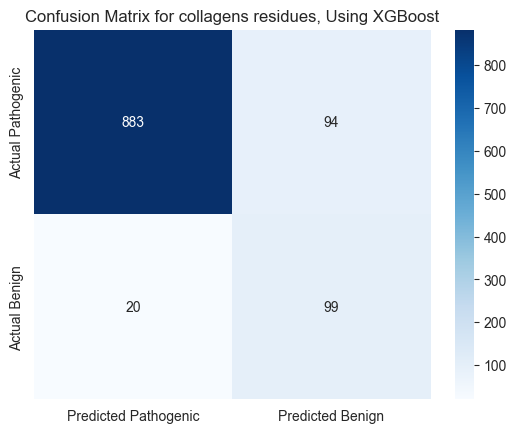

In [90]:
# Present the results in a confusion matrix, using TP, FP, FN, TN.
confusion_matrix = pd.DataFrame({"Predicted Pathogenic": [TP, FP], "Predicted Benign": [FN, TN]},
                                index=["Actual Pathogenic", "Actual Benign"])
print(confusion_matrix)

# Plot using seaborn, with light colors.
sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues')
plt.title(f"Confusion Matrix for {protein_type} residues, Using XGBoost")
plt.show()


In [91]:
data["gene"].unique()

array(['COL11A1', 'COL4A3', 'COL9A3', 'COL11A2', 'COL4A5', 'COL2A1',
       'COL4A4', 'COL9A1', 'COL9A2', 'COL4A6'], dtype=object)

In [92]:
predictions_df

,gene,variant,prediction,reality
0,COL11A1,G1249V,1,1
1,COL11A1,G1516V,1,1
2,COL11A1,R1733C,1,1
3,COL11A1,G1800C,1,1
4,COL11A1,R1076C,1,1
...,...,...,...,...
1091,COL9A2,G30R,1,0
1092,COL9A2,A336E,1,0
1093,COL9A2,L335V,0,0
1094,COL9A2,R32Q,0,0


In [93]:
# Check how many predictions were correct.
correct_predictions = predictions_df[predictions_df["prediction"] == predictions_df["reality"]]
# Calculate the accuracy of the model.
accuracy = len(correct_predictions) / len(predictions_df)

In [94]:
accuracy

0.8959854014598541

In [95]:
# Save the predictions to a file.
predictions_df.to_csv(f"C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\{protein_type}_{residues_or_proteins}\\predictions_vs_real_{protein_type}_{residues_or_proteins}.csv", index=False)

In [96]:
# Calculate per-protein accuracy, and save each protein's accuracy to a file.
proteins = predictions_df["gene"].unique()
accuracies = []
for protein in proteins:
    protein_df = predictions_df[predictions_df["gene"] == protein]
    correct_predictions = protein_df[protein_df["prediction"] == protein_df["reality"]]
    accuracy = len(correct_predictions) / len(protein_df)
    accuracies.append(accuracy)
    print(f"Accuracy for protein {protein}: {accuracy}")


Accuracy for protein COL11A1: 0.9047619047619048
Accuracy for protein COL4A3: 0.8689655172413793
Accuracy for protein COL9A3: 0.8
Accuracy for protein COL11A2: 0.625
Accuracy for protein COL4A5: 0.9428571428571428
Accuracy for protein COL2A1: 0.8851351351351351
Accuracy for protein COL4A4: 0.9
Accuracy for protein COL9A1: 1.0
Accuracy for protein COL9A2: 0.7142857142857143
Accuracy for protein COL4A6: 0.0


In [97]:
# Calculate per-protein metrics, and save each protein's metrics to a file.
proteins = predictions_df["gene"].unique()
metrics = pd.DataFrame(columns=["gene", "sensitivity", "specificity", "precision", "accuracy", "mcc", "num_variants", "num_benign", "num_pathogenic"])
for protein in proteins:
    protein_df = predictions_df[predictions_df["gene"] == protein]
    TP = sum(protein_df["prediction"] & protein_df["reality"])
    FP = sum((protein_df["reality"] == 0) & (protein_df["prediction"] == 1))
    FN = sum((protein_df["reality"] == 1) & (protein_df["prediction"] == 0))
    TN = sum((protein_df["reality"] == 0) & (protein_df["prediction"] == 0))
    # to not divide by zero, check if there are any true positives, false positives, false negatives, or true negatives.
    if TP == 0:
        sensitivity = 0
        precision = 0
    else:
        sensitivity = TP / (TP + FN)
        precision = TP / (TP + FP)
    if TN == 0:
        specificity = 0
    else:
        specificity = TN / (TN + FP)
    mcc = get_mcc(TP, TN, FP, FN)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    protein_metrics = pd.DataFrame({
        "gene": [protein],
        "sensitivity": [sensitivity],
        "specificity": [specificity],
        "precision": [precision],
        "accuracy": [accuracy],
        "mcc": [mcc]
    })
    protein_metrics["num_variants"] = len(protein_df)
    protein_metrics["num_benign"] = sum(protein_df["reality"] == 0)
    protein_metrics["num_pathogenic"] = sum(protein_df["reality"] == 1)
    # add TP, FP, FN, TN to the dataframe
    protein_metrics["TP"] = TP
    protein_metrics["FP"] = FP
    protein_metrics["FN"] = FN
    protein_metrics["TN"] = TN
    metrics = pd.concat([metrics, protein_metrics], ignore_index=True)
    # add the number of variants for each protein
    
metrics.to_csv(f"C:\\Users\\InbarBlech\\PycharmProjects\\Thesis\\predictions_vs_real\\{protein_type}_{residues_or_proteins}\\metrics_{protein_type}_{residues_or_proteins}.csv", index=False)

C:\Users\InbarBlech\AppData\Local\Temp\ipykernel_22724\1621015253.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics = pd.concat([metrics, protein_metrics], ignore_index=True)
